# Комментарий от ревьюера

Здравствуй, Иван! Меня зовут Влада, я посмотрела твой проект — работа превосходная, очень интересно и увлекательно было следить за ходом твоего решения :) Ниже в файле ты найдешь мои комментарии: <font color='green'>зеленый цвет — «все отлично»; </font> <font color='blue'>синий — «хорошо, но можно лучше»; </font> <font color='red'>красный — «нужно исправить».</font> Комментарии в самом коде я отделяю знаками «###».

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

### Предварительное исследование данных

Загрузим библиотеки и методы, которые могут нам понадобиться. Согласно условию, модель должна определять, уйдет ли или не уйдет клиент, соответственно целевой признак - категориальный. Поэтому загрузим классификаторы.

In [1]:
import sklearn
import joblib
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

import math

Назначим число зерном генератора псевдослучайных чисел, чтобы было легче ссылаться на него во всех моделях.

In [2]:
random = 12345

Загрузим файл и рассмотрим его.

In [3]:
df_raw = pd.read_csv('/datasets/Churn.csv')
df_raw.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В данных присутствуют отсутствующие значения признака Tenure, в остальных признаках значения отсутствуют.  
Типы данных в целом подходят для работы, однако в том же признаке Tenure стоит заменить тип данных на целочисленный, а в HasCrCard, IsActiveMember и Exited - на булев.  
Также для удобства можно заменить регистр в наименованиях столбцов, чтобы в последствии было легче обращаться к признакам.  
В первых 10 строках оказалось значение Surname H?. Несмотря на отсутствие пропусков в этом столбце, подобные значения в иных задачах пришлось бы обрабатывать каким-то образом. Однако в данном случае первые три столбца, выполняющие функции, по большому счету, идентификаторов строк и объектов, не будут участвовать в обучении модели и решении задачи, поэтому обрабатывать их смысла нет. 

Surname в набор обучающих данных не попадет, из категориальных мультиклассовых признаков будут Geography и Gender. Оценим количество классов в этих признаках.

In [5]:
df_raw['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [6]:
df_raw['Gender'].unique()

array(['Female', 'Male'], dtype=object)

Всего 3 класса признака Geography и 2 класса признака Gender. Это значит, что при применении метода ohe у нас не будет катастрофического прироста признаков.

### Наименования столбцов

Поменяем регистр, чтобы впредь было легче обращаться к названиям признаков.

In [7]:
df_raw.columns = df_raw.columns.str.lower()
df_raw.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Обработка пропусков

Проверим, сколько пропусков в столбце Tenure.

In [8]:
df_raw[df_raw['tenure'].isna() == True]

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Девятсот пропусков - это довольно много, почти 10% от выборки. Мы не можем удалить такое количество объектов, поэтому посмотрим, есть ли корреляция Tenure с каким-либо еще признаком и попробуем заполнить пропуски с его помощью. 

In [9]:
df_raw.corr()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
rownumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
customerid,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
creditscore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
numofproducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
hascrcard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
isactivemember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimatedsalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


К сожалению, проследить какую-либо ощутимую зависимость между значениями tenure какими-то другими признаками не удается, ковариционная матрица показывает отсутствие сколь-нибудь сильной связи с каким-либо из признаков.  
Однако удалять 10% выборки из-за отсутствующего признака мы не будем. Заполним пропуски в этом столбце медианами в разбивке по hascrcard и isactivemember, которые по не очевидной причине имеют чуть более выраженную связь с tenure, чем остальные признаки.

In [10]:

pivot_salary = df_raw.pivot_table(
    index = 'hascrcard',
    columns = 'isactivemember',
    values = 'tenure', 
    aggfunc = 'median')

def tenure_filling1(row):
    card = row['hascrcard']
    active = row['isactivemember']
    tenure = row['tenure']
    try:
        return pivot_salary.loc[card, active]
    except:
        return tenure
    

df_raw.loc[df_raw['tenure'].isnull()==True, 'tenure'] = df_raw[df_raw['tenure'].isnull()==True].apply(tenure_filling1,axis=1)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<font color='green'>Здорово, очень интересная идея для обработки пропусков. </font>


### Обработка дубликатов

Проверим данные на наличие дубликатов. При проверке исключим столбцы, отвечающие за идентификацию строки, из-за которых строки независимо от того, одинаковые ли у них сочетания признаков, будут определены как уникальные.

In [11]:
df_raw.drop(['rownumber','customerid'], axis=1).duplicated().sum()

0

<font color='green'>Отлично, идем дальше. </font>


### Замена типов данных

Заменим в признаках hascrcard, isactivemember и exited тип данных на булевый. Также заменим тип данных в признаке tenure

In [12]:
df_raw.loc[:,['hascrcard', 'isactivemember', 'exited']] = df_raw.loc[:,['hascrcard', 'isactivemember', 'exited']].astype('bool')
df_raw['tenure'] = df_raw['tenure'].astype('int')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null int64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null bool
isactivemember     10000 non-null bool
estimatedsalary    10000 non-null float64
exited             10000 non-null bool
dtypes: bool(3), float64(2), int64(6), object(3)
memory usage: 888.8+ KB


### Исключение столбцов. Масштабирование признаков

Перед тем, как примять технику прямого кодирования, избавимся от признаков, которые мы не будем использовать для обучения моделей, то есть первые три столбца.

In [13]:
df = df_raw.drop(['rownumber', 'customerid','surname'], axis = 1)

<font color='green'>Совершенно верно, эти признаки неинформативны. </font>


In [14]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null float64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null float64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null float64
hascrcard          10000 non-null bool
isactivemember     10000 non-null bool
estimatedsalary    10000 non-null float64
exited             10000 non-null bool
dtypes: bool(3), float64(6), object(2)
memory usage: 654.4+ KB


<font color='green'>Правильно, масштабирование необходимо. </font> <font color='blue'>Лучше было разбить выборку на обучающую, валидационную и тестовую, а после этого настроить scaler только на обучающей выборке (для валидационной и тестовой использовать метод transform настроенного scaler). Тестовая выборка не должна принимать участие в построении модели классификации.</font>


### Прямое кодирование категориальных признаков

Применим метод OHE. Он универсален и подойдет любому типу алгоритмов из тех, что мы будем использовать.  

In [15]:
df_ohe = pd.get_dummies(df, drop_first = True)
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
creditscore          10000 non-null float64
age                  10000 non-null float64
tenure               10000 non-null float64
balance              10000 non-null float64
numofproducts        10000 non-null float64
hascrcard            10000 non-null bool
isactivemember       10000 non-null bool
estimatedsalary      10000 non-null float64
exited               10000 non-null bool
geography_Germany    10000 non-null uint8
geography_Spain      10000 non-null uint8
gender_Male          10000 non-null uint8
dtypes: bool(3), float64(6), uint8(3)
memory usage: 527.5 KB


In [16]:
df_ohe.head(10)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,-0.326221,0.293517,-1.086246,-1.225848,-0.911583,True,True,0.021886,True,0,0,0
1,-0.440036,0.198164,-1.448581,0.117350,-0.911583,False,True,0.216534,False,0,1,0
2,-1.536794,0.293517,1.087768,1.333053,2.527057,True,False,0.240687,True,0,0,0
3,0.501521,0.007457,-1.448581,-1.225848,0.807737,False,False,-0.108918,False,0,0,0
4,2.063884,0.388871,-1.086246,0.785728,-0.911583,True,True,-0.365276,False,0,1,0
5,-0.057205,0.484225,1.087768,0.597329,0.807737,True,False,0.863650,True,0,1,1
6,1.774174,1.056346,0.725432,-1.225848,0.807737,True,True,-1.565487,False,0,0,1
7,-2.840488,-0.946079,-0.361575,0.618019,4.246377,True,False,0.334854,True,1,0,0
8,-1.547141,0.484225,-0.361575,1.050820,0.807737,False,True,-0.437329,False,0,0,1
9,0.346319,-1.136786,-1.086246,0.931463,-0.911583,True,True,-0.493230,False,0,0,1


<font color='green'>Отлично, все в порядке. </font>


### Порядковое кодирование категориальных признаков

Подготовим также данные, в которых применяется метод порядкового кодирования категориальных признаков. Он может пригодиться нам для обучения моделей с помощью дерева решений или случайного леса.   

In [17]:
ordin_encod=OrdinalEncoder()
ordin_encod.fit(df)
df_ordin = pd.DataFrame(ordin_encod.transform(df), columns = df.columns)
df_ordin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null float64
geography          10000 non-null float64
gender             10000 non-null float64
age                10000 non-null float64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null float64
hascrcard          10000 non-null float64
isactivemember     10000 non-null float64
estimatedsalary    10000 non-null float64
exited             10000 non-null float64
dtypes: float64(11)
memory usage: 859.5 KB


In [18]:
df_ordin.head(10)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0
5,254.0,2.0,1.0,26.0,8.0,2674.0,1.0,1.0,0.0,7531.0,1.0
6,431.0,0.0,1.0,32.0,7.0,0.0,1.0,1.0,1.0,513.0,0.0
7,8.0,1.0,0.0,11.0,4.0,2781.0,3.0,1.0,0.0,5978.0,1.0
8,110.0,0.0,1.0,26.0,4.0,4962.0,1.0,0.0,1.0,3718.0,0.0
9,293.0,0.0,1.0,9.0,2.0,4450.0,0.0,1.0,1.0,3550.0,0.0


<font color='green'>Хорошо, переходим к следующему шагу. </font>

# 2. Исследование задачи

Исследуем распределение классов по общему количеству объектов.

In [19]:
df.query('exited == 1')['exited'].count()

2037

Объекты с положительным значением целевого признака составляют чуть более 20% от общего набора данных, присутствует значительный дисбаланс классов целевого признака.  

<font color='green'>Все верно. </font>

В целях исследования задачи обучим модели без учета дисбаланса классов и изучим получившиеся результаты.

In [20]:
ohe_features = df_ohe.drop('exited', axis = 1)
ohe_target = df_ohe['exited']
ohe_features_train, ohe_features_valid_test, ohe_target_train, ohe_target_valid_test = train_test_split(
    ohe_features, ohe_target, 
    test_size = 0.4, stratify = ohe_target,
    random_state = random) 
ohe_features_valid, ohe_features_test, ohe_target_valid, ohe_target_test = train_test_split(
    ohe_features_valid_test, ohe_target_valid_test, 
    test_size = 0.5, stratify = ohe_target_valid_test,
    random_state = random)

In [21]:
ordin_features = df_ordin.drop('exited', axis = 1)
ordin_target = df_ordin['exited']
ordin_features_train, ordin_features_valid_test, ordin_target_train, ordin_target_valid_test = train_test_split(
    ordin_features, ordin_target, 
    test_size = 0.3, stratify = ordin_target,
    random_state = random) 
ordin_features_valid, ordin_features_test, ordin_target_valid, ordin_target_test = train_test_split(
    ordin_features_valid_test, ordin_target_valid_test, 
    test_size = 0.5, stratify = ordin_target_valid_test,
    random_state = random)

### Дерево решений без учета дисбаланса

Проверим, какие результаты покажут модели, созданные на алогоритмах дерева решений и обученные на данных OHE, обработанных методом ohe и порядковым кодированием.

Проведем перебор сочетаний гиперпараметров для дерева решений, обученных на данных с OHE.

In [22]:
%%time

tree_depth_col = []
tree_min_leaf_col = []
tree_min_split_col = []
tree_acc_col = []
tree_f1_col = []
tree_recall_col = []
tree_precision_col = []
tree_roc_auc_col = []

for depth in range(2, 21, 2):
    for min_leaf in range(1, 10, 2):
        for min_split in range(2,10,2):
            model_tree_ohe = DecisionTreeClassifier(max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
            model_tree_ohe.fit(ohe_features_train, ohe_target_train)
            predicted_valid_tree_ohe = model_tree_ohe.predict(ohe_features_valid)
            acc_score_tree = accuracy_score(ohe_target_valid, predicted_valid_tree_ohe)
            f1_score_tree = f1_score(ohe_target_valid, predicted_valid_tree_ohe)
            recall_score_tree = recall_score(ohe_target_valid, predicted_valid_tree_ohe)
            precision_score_tree = precision_score(ohe_target_valid, predicted_valid_tree_ohe)
            probabilities_tree_ohe = model_tree_ohe.predict_proba(ohe_features_valid)
            probabilities_one_tree_ohe = probabilities_tree_ohe[:, 1]
            roc_auc_score_tree = roc_auc_score(ohe_target_valid, probabilities_one_tree_ohe)
            tree_depth_col.append(depth)
            tree_min_split_col.append(min_split)
            tree_min_leaf_col.append(min_leaf)
            tree_acc_col.append(acc_score_tree)
            tree_f1_col.append(f1_score_tree)
            tree_recall_col.append(recall_score_tree)
            tree_precision_col.append(precision_score_tree)
            tree_roc_auc_col.append(roc_auc_score_tree)
        
ohe_tree_hyperparameters_dict = {
    'max_depth': tree_depth_col, 
    'min_samples_split': tree_min_split_col, 
    'min_samples_leaf': tree_min_leaf_col, 
    'accuracy_score': tree_acc_col, 
    'recall_score': tree_recall_col,
    'precision_score': tree_precision_col, 
    'f1_score':tree_f1_col, 
    'roc_auc_score': tree_roc_auc_col}
ohe_tree_hyperparameters = pd.DataFrame(data = ohe_tree_hyperparameters_dict)
ohe_tree_hyperparameters

CPU times: user 7.88 s, sys: 48 ms, total: 7.93 s
Wall time: 7.96 s


,max_depth,min_samples_split,min_samples_leaf,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
0,2,2,1,0.8350,0.438725,0.639286,0.520349,0.753960
1,2,4,1,0.8350,0.438725,0.639286,0.520349,0.753960
2,2,6,1,0.8350,0.438725,0.639286,0.520349,0.753960
3,2,8,1,0.8350,0.438725,0.639286,0.520349,0.753960
4,2,2,3,0.8350,0.438725,0.639286,0.520349,0.753960
...,...,...,...,...,...,...,...,...
195,20,8,7,0.8255,0.534314,0.578249,0.555414,0.769936
196,20,2,9,0.8330,0.507353,0.608824,0.553476,0.795547
197,20,4,9,0.8330,0.507353,0.608824,0.553476,0.795547
198,20,6,9,0.8330,0.507353,0.608824,0.553476,0.795547


Проведем перебор гипермараметров для дерева решений, обученного на данных с порядковым кодированием категориальных признаков. 

In [23]:
%%time

tree_depth_col = []
tree_min_leaf_col = []
tree_min_split_col = []
tree_acc_col = []
tree_f1_col = []
tree_recall_col = []
tree_precision_col = []
tree_roc_auc_col = []

for depth in range(2, 21, 2):
    for min_leaf in range(1, 10, 2):
        for min_split in range(2,10,2):
            model_tree_ordin = DecisionTreeClassifier(max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
            model_tree_ordin.fit(ordin_features_train, ordin_target_train)
            predicted_valid_tree_ordin = model_tree_ordin.predict(ordin_features_valid)
            acc_score_tree = accuracy_score(ordin_target_valid, predicted_valid_tree_ordin)
            f1_score_tree = f1_score(ordin_target_valid, predicted_valid_tree_ordin)
            recall_score_tree = recall_score(ordin_target_valid, predicted_valid_tree_ordin)
            precision_score_tree = precision_score(ordin_target_valid, predicted_valid_tree_ordin)
            probabilities_tree_ordin = model_tree_ordin.predict_proba(ordin_features_valid)
            probabilities_one_tree_ordin = probabilities_tree_ordin[:, 1]
            roc_auc_score_tree = roc_auc_score(ordin_target_valid, probabilities_one_tree_ordin)
            tree_depth_col.append(depth)
            tree_min_split_col.append(min_split)
            tree_min_leaf_col.append(min_leaf)
            tree_acc_col.append(acc_score_tree)
            tree_f1_col.append(f1_score_tree)
            tree_recall_col.append(recall_score_tree)
            tree_precision_col.append(precision_score_tree)
            tree_roc_auc_col.append(roc_auc_score_tree)
        
ordin_tree_hyperparameters_dict = {
    'max_depth': tree_depth_col, 
    'min_samples_split': tree_min_split_col, 
    'min_samples_leaf': tree_min_leaf_col, 
    'accuracy_score': tree_acc_col, 
    'recall_score': tree_recall_col,
    'precision_score': tree_precision_col, 
    'f1_score':tree_f1_col, 
    'roc_auc_score': tree_roc_auc_col}
ordin_tree_hyperparameters = pd.DataFrame(data = ordin_tree_hyperparameters_dict)
ordin_tree_hyperparameters

CPU times: user 7.84 s, sys: 16 ms, total: 7.86 s
Wall time: 7.86 s


,max_depth,min_samples_split,min_samples_leaf,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
0,2,2,1,0.821333,0.421569,0.586364,0.490494,0.757428
1,2,4,1,0.821333,0.421569,0.586364,0.490494,0.757428
2,2,6,1,0.821333,0.421569,0.586364,0.490494,0.757428
3,2,8,1,0.821333,0.421569,0.586364,0.490494,0.757428
4,2,2,3,0.821333,0.421569,0.586364,0.490494,0.757428
...,...,...,...,...,...,...,...,...
195,20,8,7,0.824667,0.483660,0.584980,0.529517,0.770332
196,20,2,9,0.834000,0.483660,0.619247,0.543119,0.771398
197,20,4,9,0.834000,0.483660,0.619247,0.543119,0.771398
198,20,6,9,0.834000,0.483660,0.619247,0.543119,0.771398


Выведем строки с максимальным значением f1.

In [24]:
ordin_tree_hyperparameters.query('f1_score == f1_score.max()')

,max_depth,min_samples_split,min_samples_leaf,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
116,12,2,9,0.834,0.486928,0.618257,0.54479,0.779387
117,12,4,9,0.834,0.486928,0.618257,0.54479,0.779387
118,12,6,9,0.834,0.486928,0.618257,0.54479,0.779387
119,12,8,9,0.834,0.486928,0.618257,0.54479,0.779387


In [25]:
ohe_tree_hyperparameters.query('f1_score == f1_score.max()')

,max_depth,min_samples_split,min_samples_leaf,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
52,6,2,7,0.8625,0.480392,0.756757,0.587706,0.842704
53,6,4,7,0.8625,0.480392,0.756757,0.587706,0.842704
54,6,6,7,0.8625,0.480392,0.756757,0.587706,0.842704
55,6,8,7,0.8625,0.480392,0.756757,0.587706,0.842704


Максимальное значение f1 у модели, обученной на данных с прямым кодированием категориальных признаков. Это довольно интересно, учитывая, что порядковое кодирование лучше подходят для деревьев решений и случайного леса.

В любом случае, значения f1 дерева решений слишком низкие, на тестовой это значение с большой вероятностью упадет.

In [26]:
ohe_tree_hyperparameters['roc_auc_score'].mean()

0.7854342022613064

In [27]:
ohe_tree_hyperparameters['roc_auc_score'].median()

0.7849872832298748

In [28]:
ordin_tree_hyperparameters['roc_auc_score'].mean()

0.7788252947745263

In [29]:
ordin_tree_hyperparameters['roc_auc_score'].median()

0.7711172967232677

Примечательно, что несмотря на неудовлетворительный результат метрики f1, показатель площади под кривой ROC довольно высокий и у алгоритмов, использующих данные, обработанные методом OHE, и у алгоритмов на данных с порядковым кодированием признаков. У алгоритмов с данными OHE показатель ROC-AUC выше, хотя и несильно, больше эта разница заметна на моделях с лучшим показателем f1. У лучшей модели деревьев кривая выглядит следующим образом:

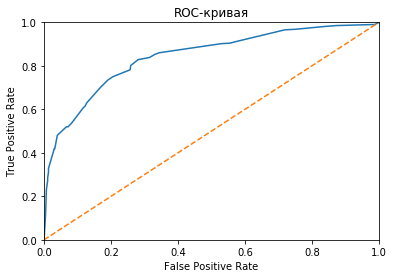

In [30]:
best_tree_depth = int(ohe_tree_hyperparameters.query('f1_score == f1_score.max()')['max_depth'].head(1))
best_tree_split = int(ohe_tree_hyperparameters.query('f1_score == f1_score.max()')['min_samples_split'].head(1))
best_tree_leaf = int(ohe_tree_hyperparameters.query('f1_score == f1_score.max()')['min_samples_leaf'].head(1))


best_tree_model = DecisionTreeClassifier(
    max_depth = best_tree_depth, 
    min_samples_split = best_tree_split, 
    min_samples_leaf = best_tree_leaf,
    random_state = random)
best_tree_model.fit(ohe_features_train, ohe_target_train)
probabilities_tree_valid = best_tree_model.predict_proba(ohe_features_valid)
probabilities_one_tree_valid = probabilities_tree_valid[:, 1]

fpr, tpr, thresholds = roc_curve(ohe_target_valid, probabilities_one_tree_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

<font color='green'>Очень подробный отчет, прекрасная работа, молодец :) </font>


### Случайный лес без учета дисбаланса

Случайный лес обычно дает более точные предсказания, хотя он дольше работает, поэтому на перебор сочетаний гипермпараметров уйдет больше времени, даже несмотря на то, что мы перебираем не все подряд гиперпараметры. 

Проверим, какую точность даст случайный лес, обученный на данных OHE:

In [31]:
%%time

forest_depth_col = []
forest_estim_col = []
forest_min_leaf_col = []
forest_min_split_col = []
forest_score_col = []
forest_f1_col = []
forest_recall_col = []
forest_precision_col = []
forest_roc_auc_col = []

for depth in range(6,16,2):
    for min_leaf in range(1, 6, 2):
        for min_split in range(2,8,2):
            for estim in range(20, 110, 10):
                model_forest_ohe = RandomForestClassifier(n_estimators = estim, max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
                model_forest_ohe.fit(ohe_features_train, ohe_target_train)
                predicted_valid_forest_ohe = model_forest_ohe.predict(ohe_features_valid)
                score_forest = model_forest_ohe.score(ohe_features_valid, ohe_target_valid)
                recall_score_forest = recall_score(ohe_target_valid, predicted_valid_forest_ohe)
                precision_score_forest = precision_score(ohe_target_valid, predicted_valid_forest_ohe)
                probabilities_forest_ohe = model_forest_ohe.predict_proba(ohe_features_valid)
                probabilities_one_forest_ohe = probabilities_forest_ohe[:, 1]
                roc_auc_score_forest = roc_auc_score(ohe_target_valid, probabilities_one_forest_ohe)
                f1_forest = f1_score(ohe_target_valid, predicted_valid_forest_ohe)
                forest_depth_col.append(depth)
                forest_min_leaf_col.append(min_leaf)
                forest_min_split_col.append(min_split)
                forest_estim_col.append(estim)
                forest_score_col.append(score_forest)
                forest_recall_col.append(recall_score_forest)
                forest_precision_col.append(precision_score_forest)
                forest_f1_col.append(f1_forest)
                forest_roc_auc_col.append(roc_auc_score_forest)
        
        
ohe_forest_hyperparameters_dict = {
    'max_depth': forest_depth_col, 
    'n_estimators': forest_estim_col, 
    'min_samples_split': forest_min_split_col, 
    'min_samples_leaf': forest_min_leaf_col, 
    'score': forest_score_col,
    'recall_score': forest_recall_col,
    'precision_score': forest_precision_col,
    'f1_score': forest_f1_col, 
    'roc_auc_score': forest_roc_auc_col}
ohe_forest_hyperparameters = pd.DataFrame(data = ohe_forest_hyperparameters_dict)
ohe_forest_hyperparameters

CPU times: user 3min 21s, sys: 1.29 s, total: 3min 22s
Wall time: 3min 23s


,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
0,6,20,2,1,0.8590,0.416667,0.794393,0.546624,0.864602
1,6,30,2,1,0.8590,0.414216,0.797170,0.545161,0.869130
2,6,40,2,1,0.8585,0.406863,0.801932,0.539837,0.871086
3,6,50,2,1,0.8580,0.409314,0.795238,0.540453,0.870197
4,6,60,2,1,0.8565,0.394608,0.800995,0.528736,0.870458
...,...,...,...,...,...,...,...,...,...
400,14,60,6,5,0.8635,0.475490,0.766798,0.586989,0.872760
401,14,70,6,5,0.8640,0.473039,0.772000,0.586626,0.873653
402,14,80,6,5,0.8660,0.475490,0.782258,0.591463,0.874249
403,14,90,6,5,0.8655,0.473039,0.781377,0.589313,0.874187


Посмотрим, какие результаты выдаст случайный лес на основе данных, обработанных с помощью порядкового кодирования:

In [32]:
%%time

forest_depth_col = []
forest_estim_col = []
forest_min_leaf_col = []
forest_min_split_col = []
forest_score_col = []
forest_f1_col = []
forest_recall_col = []
forest_precision_col = []
forest_roc_auc_col = []

for depth in range(6,16,2):
    for min_leaf in range(1, 6, 2):
        for min_split in range(2,8,2):
            for estim in range(20, 110, 10):
                model_forest_ordin = RandomForestClassifier(n_estimators = estim, max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
                model_forest_ordin.fit(ordin_features_train, ordin_target_train)
                predicted_valid_forest_ordin = model_forest_ordin.predict(ordin_features_valid)
                score_forest = model_forest_ordin.score(ordin_features_valid, ordin_target_valid)
                recall_score_forest = recall_score(ordin_target_valid, predicted_valid_forest_ordin)
                precision_score_forest = precision_score(ordin_target_valid, predicted_valid_forest_ordin)
                probabilities_forest_ordin = model_forest_ordin.predict_proba(ordin_features_valid)
                probabilities_one_forest_ordin = probabilities_forest_ordin[:, 1]
                roc_auc_score_forest = roc_auc_score(ordin_target_valid, probabilities_one_forest_ordin)
                f1_forest = f1_score(ordin_target_valid, predicted_valid_forest_ordin)
                forest_depth_col.append(depth)
                forest_min_leaf_col.append(min_leaf)
                forest_min_split_col.append(min_split)
                forest_estim_col.append(estim)
                forest_score_col.append(score_forest)
                forest_recall_col.append(recall_score_forest)
                forest_precision_col.append(precision_score_forest)
                forest_f1_col.append(f1_forest)
                forest_roc_auc_col.append(roc_auc_score_forest)
        
        
ordin_forest_hyperparameters_dict = {
    'max_depth': forest_depth_col, 
    'n_estimators': forest_estim_col, 
    'min_samples_split': forest_min_split_col, 
    'min_samples_leaf': forest_min_leaf_col, 
    'score': forest_score_col,
    'recall_score': forest_recall_col,
    'precision_score': forest_precision_col,
    'f1_score': forest_f1_col, 
    'roc_auc_score': forest_roc_auc_col}
ordin_forest_hyperparameters = pd.DataFrame(data = ordin_forest_hyperparameters_dict)
ordin_forest_hyperparameters

CPU times: user 3min 57s, sys: 2 s, total: 3min 59s
Wall time: 3min 59s


,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
0,6,20,2,1,0.855333,0.372549,0.820144,0.512360,0.863974
1,6,30,2,1,0.853333,0.372549,0.802817,0.508929,0.863585
2,6,40,2,1,0.854667,0.379085,0.805556,0.515556,0.865515
3,6,50,2,1,0.854000,0.385621,0.791946,0.518681,0.864732
4,6,60,2,1,0.853333,0.382353,0.790541,0.515419,0.864233
...,...,...,...,...,...,...,...,...,...
400,14,60,6,5,0.861333,0.415033,0.814103,0.549784,0.862816
401,14,70,6,5,0.862667,0.415033,0.824675,0.552174,0.864157
402,14,80,6,5,0.861333,0.408497,0.822368,0.545852,0.865050
403,14,90,6,5,0.860667,0.408497,0.816993,0.544662,0.865649


In [33]:
best_ordin_forest = ordin_forest_hyperparameters.query('f1_score == f1_score.max()')
best_ordin_forest

,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
324,14,20,2,1,0.861333,0.444444,0.781609,0.566667,0.851344


In [34]:
best_ohe_forest = ohe_forest_hyperparameters.query('f1_score == f1_score.max()')
best_ohe_forest

,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
351,14,20,2,3,0.873,0.514706,0.789474,0.623145,0.865271
360,14,20,4,3,0.873,0.514706,0.789474,0.623145,0.865271
369,14,20,6,3,0.873,0.514706,0.789474,0.623145,0.865271


In [35]:
best_ordin_forest_depth = int(best_ordin_forest['max_depth'].head(1))
best_ordin_forest_n_estimators = int(best_ordin_forest['n_estimators'].head(1))
best_ordin_forest_split = int(best_ordin_forest['min_samples_split'].head(1))
best_ordin_forest_leaf = int(best_ordin_forest['min_samples_leaf'].head(1))

best_ohe_forest_depth = int(best_ohe_forest['max_depth'].head(1))
best_ohe_forest_n_estimators = int(best_ohe_forest['n_estimators'].head(1))
best_ohe_forest_split = int(best_ohe_forest['min_samples_split'].head(1))
best_ohe_forest_leaf = int(best_ohe_forest['min_samples_leaf'].head(1))


Значение f1 метрики составляет более 62 сотых, превышяя пороговое. Примечательно, что, несмотря на то, что техника порядкового кодирования категориальных признаков вроде как должна демонстрировать лучшие результаты при использовании алгоритмов дерева решений или случайного леса, лучший результат получен на основе данных, обработанных с помощью прямого кодирования.

Проверим, какое значение получится на тестовой выборке. Обучим модель на основе алогоритма с гиперпараметрами, при которых получилось наибольшее значение f1-метрики. Заодно сразу вызовем матрицу ошибок.

In [36]:
best_ordin_forest_model = RandomForestClassifier(
    max_depth = best_ordin_forest_depth, 
    n_estimators = best_ordin_forest_n_estimators, 
    min_samples_split = best_ordin_forest_split, 
    min_samples_leaf = best_ordin_forest_leaf, 
    random_state = random)
best_ordin_forest_model.fit(ordin_features_train, ordin_target_train)
best_ordin_predicted_valid = best_ordin_forest_model.predict(ordin_features_valid)
confusion_matrix(ordin_target_valid, best_ordin_predicted_valid)

array([[1156,   38],
       [ 170,  136]])

In [37]:
best_ordin_predicted_test = best_ordin_forest_model.predict(ordin_features_test)
confusion_matrix(ordin_target_test, best_ordin_predicted_test)

array([[1135,   60],
       [ 151,  154]])

In [38]:
f1_score(ordin_target_test, best_ordin_predicted_test)

0.5934489402697495

Видим, что f1-метрика на тестовом наборе данных, обработанных порядковой техникой кодирования, демонстирует гораздо большее значение, чем на валидационной. Это не совсем тривиальное развитие событий.  
Мы не будем рассматривать этот вариант модели как успешный, по причине того, что проверили f1 метрику на всякий случай. При прочих равных, будь в нашем арсенале больше методов или алгоритмов, мы бы отмели этот вариант по неудовлетворительным результатам, полученным на валидационной выборке.  

<font color='green'>Да, действительно, ориентироваться нужно только на валидационную выборку. Тестовая выборка нужна только для оценивания качества лучшей модели.</font>

In [39]:
best_ohe_forest_model = RandomForestClassifier(
    max_depth = best_ohe_forest_depth, 
    n_estimators = best_ohe_forest_n_estimators, 
    min_samples_split = best_ohe_forest_split, 
    min_samples_leaf = best_ohe_forest_leaf, 
    random_state = random)
best_ohe_forest_model.fit(ohe_features_train, ohe_target_train)
best_ohe_predicted_valid = best_ohe_forest_model.predict(ohe_features_valid)
confusion_matrix(ohe_target_valid, best_ohe_predicted_valid)

array([[1536,   56],
       [ 198,  210]])

In [40]:
best_ohe_predicted_test = best_ohe_forest_model.predict(ohe_features_test)
confusion_matrix(ohe_target_test, best_ohe_predicted_test)

array([[1529,   64],
       [ 230,  177]])

In [41]:
f1_score(ohe_target_test, best_ohe_predicted_test)

0.5462962962962963

Модель, обученная на данных, обработанных с помощью OHE, демонстрирует неудовлетворительный результат. 

Обратимся к вызванным нами матрицам ошибок: из них можно заметить, что во всех случаях ошибок первого рода не так много, в то время как ложноотрицательных значений заметно больше, и по количеству они сопоставимы с истинно положительными.  
Можно также наблюдать, что понижение качества предсказания в случае с OHE обусловленно в первую очередь перераспределением результатов от истинно положительных к ложноотрицательным. То есть ухудшение качество происходит из-за того, что склонна не замечать положительные ответы и с изменением набора признаков эта склонность усугубляется.  
Все это позволяет нам определить, что основной потенциал улучшения качества - в улучшении способности модели определять положительные значения.

Примечательно, что показатель площади под кривой ROC практически не изменился, несмотря на значительное понижение метрики f1. 

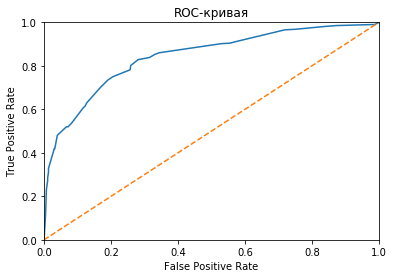

In [42]:
probabilities_forest_valid = best_ohe_forest_model.predict_proba(ohe_features_valid)
probabilities_one_forest_valid = probabilities_tree_valid[:, 1]

fpr, tpr, thresholds = roc_curve(ohe_target_valid, probabilities_one_forest_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [43]:
roc_auc_score(ohe_target_valid, probabilities_one_forest_valid)

0.8427038686077446

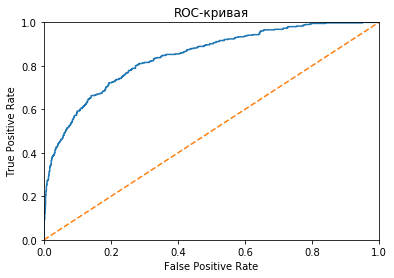

In [44]:
probabilities_forest_test = best_ohe_forest_model.predict_proba(ohe_features_test)
probabilities_one_forest_test = probabilities_forest_test[:, 1]

fpr, tpr, thresholds = roc_curve(ohe_target_test, probabilities_one_forest_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [45]:
roc_auc_score(ohe_target_test, probabilities_one_forest_test)

0.8434158349412586

In [46]:
print('ohe')
print(ohe_forest_hyperparameters['roc_auc_score'].mean())
print(ohe_forest_hyperparameters['roc_auc_score'].median())
print()
print('ordin')
print(ordin_forest_hyperparameters['roc_auc_score'].mean())
print(ordin_forest_hyperparameters['roc_auc_score'].median())

ohe
0.8703551990465521
0.8705799216671593

ordin
0.8649279744157728
0.8651317590129296


В целом, как и в случае с деревьями решений, при не очень высоких значениях f1 значения roc-auc весьма высоки. 

<font color='green'>Очень подробное исследование, выше всяких похвал :) </font>


### Логистическая регрессия без учета дисбаланса

Построим логистическую регрессию. Данные, обработанные порядковым кодированием, применять не будем.

In [47]:
model_reg = LogisticRegression(solver = 'liblinear')
model_reg.fit(ohe_features_train, ohe_target_train)
predicted_valid_reg = model_reg.predict(ohe_features_valid)
f1_score(ohe_target_valid, predicted_valid_reg)

0.3076923076923077

Результат заметно ниже, чем у других алгоритмов.

### Выводы

Потенциал для увеличения качества модели - в борьбе с дисбалансом. Лучшие результаты продемонстировал случайный лес на основе данных, обработанных OHE.

# 3. Борьба с дисбалансом

Применим методы борьбы с дисбалансом классов. Случайный лес, обученный на данных, обработанных с помощью прямого кодирования, продемонстрировал лучший результат. Сосредоточимся на нем.

### Взвешивание классов

Попробуем побороть дисбаланс, используя возможности RandomForestClassifier, а именно аргумент class_weight.

In [48]:
best_ohe_forest_model_balanced = RandomForestClassifier(
    max_depth = best_ohe_forest_depth, 
    n_estimators = best_ohe_forest_n_estimators, 
    min_samples_split = best_ohe_forest_split, 
    min_samples_leaf = best_ohe_forest_leaf, 
    random_state = random, class_weight = 'balanced')
best_ohe_forest_model_balanced.fit(ohe_features_train, ohe_target_train)
best_ohe_predicted_valid_balanced = best_ohe_forest_model_balanced.predict(ohe_features_valid)
f1_score(ohe_target_valid, best_ohe_predicted_valid_balanced)

0.6226175349428209

Результат на валидационной выборке получился неплохим, однако на тестовом наборе данных значение f1 падает.

In [49]:
best_ohe_predicted_test_balanced = best_ohe_forest_model_balanced.predict(ohe_features_test)
f1_score(ohe_target_test, best_ohe_predicted_test_balanced)

0.5758754863813229

<font color='blue'>К тестовой выборке лучше обращаться только в самом конце, после выбора наилучшей модели на валидации. </font>

На всякий случай проверим, как с указанием этого агумента сработает логистическая регрессия:

In [50]:
model_reg2 = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
model_reg2.fit(ohe_features_train, ohe_target_train)
predicted_valid_reg2 = model_reg2.predict(ohe_features_valid)
f1_score(ohe_target_valid, predicted_valid_reg2)

0.5289982425307558

Результат гораздо выше, чем без балансировки классов в логистической регрессии, но все равно заметно ниже порогового.

### Увеличение выборки

Применим метод увеличения выборки за счет строк с положительным целевым признаком. Для этого напишем функцию, принимающую на вход набор данных с нецелевыми признаками, набор с целевым признаком и множитель строк с положительным целевым признаком, и выдающий два набора - с целевым и нецелевыми признаками - с увеличенным количеством строк с положительным целевым признаком.

In [51]:
def upsampling(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Рассчитаем множитель repeat таким образом, чтобы доли нулей и единиц в целевом признаке были приблизительно равны.  
Точного разбиения 50/50 у нас может не получиться, потому что множитель будет целым числом и его придется округлить.

In [52]:
exited_ones = df_ohe.query('exited == 1')['exited'].count()
exited_zeros = df_ohe['exited'].count() - exited_ones
upsampling_repeat = math.ceil(exited_zeros / exited_ones)
upsampling_repeat

4

Применим функцию.

In [53]:
features_upsampled, target_upsampled = upsampling(ohe_features_train, ohe_target_train, upsampling_repeat)
features_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9666 entries, 6785 to 3142
Data columns (total 11 columns):
creditscore          9666 non-null float64
age                  9666 non-null float64
tenure               9666 non-null float64
balance              9666 non-null float64
numofproducts        9666 non-null float64
hascrcard            9666 non-null bool
isactivemember       9666 non-null bool
estimatedsalary      9666 non-null float64
geography_Germany    9666 non-null uint8
geography_Spain      9666 non-null uint8
gender_Male          9666 non-null uint8
dtypes: bool(2), float64(6), uint8(3)
memory usage: 575.8 KB


Проверим соотношение нулей и единиц целевого признака:

In [54]:
(target_upsampled == 1).sum() / (target_upsampled == 1).count()

0.5056900475894889

Соотношение примерно равное, можем попробовать обучить случайный лес и проверим его предсказания на валидационной и тестовой выборках.

In [55]:
best_ohe_forest_model.fit(features_upsampled, target_upsampled)
predicted_upsampled = best_ohe_forest_model.predict(ohe_features_valid)
f1_score(ohe_target_valid, predicted_upsampled)

0.6271379703534777

In [56]:
predicted_upsampled_test = best_ohe_forest_model.predict(ohe_features_test)
f1_score(ohe_target_test, predicted_upsampled_test)

0.5908558030480657

Метрика f1 на тестовом наборе данных доведена до требуемого порога. Метод upsampling помог.  

Однако в наших силах попробовать увеличить точность модели.

<font color='green'>Замечательно :) </font>


# 4. Тестирование модели

### Увеличение обучающего набора данных

До этого момента мы использовали разбиение первоначального набора данных в соотношении 60 / 20 / 20. Случайный лес - не склонный к переобучению алгоритм. Попробуем изменить соотношение на 70 / 15 / 15, увеличим обучающую выборку и проверим, не увеличит ли это качество модели.

<font color='blue'>Такой подход мне кажется сомнительным. Сравнивать качество моделей, построенных на различных обучающих выборках, и выбирать лучшую из них некорректно. Единственное, что можно было сделать – обучить итоговую модель (из предыдущего раздела) на обучающей+валидационной выборке и измерить ее качество на тестовой выборке.</font>


In [57]:
ohe_features = df_ohe.drop('exited', axis = 1)
ohe_target = df_ohe['exited']
ohe_features_train, ohe_features_valid_test, ohe_target_train, ohe_target_valid_test = train_test_split(
    ohe_features, ohe_target, 
    test_size = 0.3, stratify = ohe_target,
    random_state = random) 
ohe_features_valid, ohe_features_test, ohe_target_valid, ohe_target_test = train_test_split(
    ohe_features_valid_test, ohe_target_valid_test, 
    test_size = 0.5, stratify = ohe_target_valid_test,
    random_state = random)

In [58]:
features_upsampled2, target_upsampled2 = upsampling(ohe_features_train, ohe_target_train, upsampling_repeat)

In [59]:
%%time

forest_depth_col = []
forest_estim_col = []
forest_min_leaf_col = []
forest_min_split_col = []
forest_score_col = []
forest_f1_col = []
forest_recall_col = []
forest_precision_col = []
forest_roc_auc_col = []

for depth in range(6,16,2):
    for min_leaf in range(1, 6, 2):
        for min_split in range(2,8,2):
            for estim in range(20, 110, 10):
                model_forest_ohe2 = RandomForestClassifier(n_estimators = estim, max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
                model_forest_ohe2.fit(features_upsampled2, target_upsampled2)
                predicted_valid_forest_ohe2 = model_forest_ohe2.predict(ohe_features_valid)
                score_forest = model_forest_ohe2.score(ohe_features_valid, ohe_target_valid)
                recall_score_forest = recall_score(ohe_target_valid, predicted_valid_forest_ohe2)
                precision_score_forest = precision_score(ohe_target_valid, predicted_valid_forest_ohe2)
                probabilities_forest_ohe2 = model_forest_ohe2.predict_proba(ohe_features_valid)
                probabilities_one_forest_ohe2 = probabilities_forest_ohe2[:, 1]
                roc_auc_score_forest = roc_auc_score(ohe_target_valid, probabilities_one_forest_ohe2)
                f1_forest = f1_score(ohe_target_valid, predicted_valid_forest_ohe2)
                forest_depth_col.append(depth)
                forest_min_leaf_col.append(min_leaf)
                forest_min_split_col.append(min_split)
                forest_estim_col.append(estim)
                forest_score_col.append(score_forest)
                forest_recall_col.append(recall_score_forest)
                forest_precision_col.append(precision_score_forest)
                forest_f1_col.append(f1_forest)
                forest_roc_auc_col.append(roc_auc_score_forest)
        
        
ohe_forest_hyperparameters_dict2 = {
    'max_depth': forest_depth_col, 
    'n_estimators': forest_estim_col, 
    'min_samples_split': forest_min_split_col, 
    'min_samples_leaf': forest_min_leaf_col, 
    'score': forest_score_col,
    'recall_score': forest_recall_col,
    'precision_score': forest_precision_col,
    'f1_score': forest_f1_col, 
    'roc_auc_score': forest_roc_auc_col}
ohe_forest_hyperparameters2 = pd.DataFrame(data = ohe_forest_hyperparameters_dict2)
ohe_forest_hyperparameters2

CPU times: user 5min 31s, sys: 996 ms, total: 5min 32s
Wall time: 5min 38s


,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
0,6,20,2,1,0.800667,0.735294,0.507901,0.600801,0.863819
1,6,30,2,1,0.802667,0.751634,0.511111,0.608466,0.865426
2,6,40,2,1,0.800667,0.751634,0.507726,0.606061,0.865843
3,6,50,2,1,0.802667,0.764706,0.510917,0.612565,0.866654
4,6,60,2,1,0.798667,0.761438,0.504329,0.606771,0.865972
...,...,...,...,...,...,...,...,...,...
400,14,60,6,5,0.824000,0.656863,0.558333,0.603604,0.863180
401,14,70,6,5,0.822667,0.653595,0.555556,0.600601,0.863979
402,14,80,6,5,0.828000,0.663399,0.567039,0.611446,0.864166
403,14,90,6,5,0.827333,0.660131,0.565826,0.609351,0.864239


In [60]:
new_best_ohe_forest = ohe_forest_hyperparameters2.query('f1_score == f1_score.max()')
new_best_ohe_forest

,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
106,8,90,6,1,0.827333,0.754902,0.556627,0.640777,0.870031


In [61]:
new_best_ohe_forest_depth = int(new_best_ohe_forest['max_depth'].head(1))
new_best_ohe_forest_n_estimators = int(new_best_ohe_forest['n_estimators'].head(1))
new_best_ohe_forest_split = int(new_best_ohe_forest['min_samples_split'].head(1))
new_best_ohe_forest_leaf = int(new_best_ohe_forest['min_samples_leaf'].head(1))


In [62]:
new_best_ohe_forest_model = RandomForestClassifier(
    max_depth = new_best_ohe_forest_depth, 
    n_estimators = new_best_ohe_forest_n_estimators, 
    min_samples_split = new_best_ohe_forest_split, 
    min_samples_leaf = new_best_ohe_forest_leaf, 
    random_state = random)
new_best_ohe_forest_model.fit(features_upsampled2, target_upsampled2)
new_best_ohe_predicted_test = best_ohe_forest_model.predict(ohe_features_test)
f1_score(ohe_target_test, new_best_ohe_predicted_test)

0.6214177978883861

Мы получили модель, которая демонстрирует хорошие результаты на тестовом наборе данных. Посмотрим, как выглядит кривая ROC:

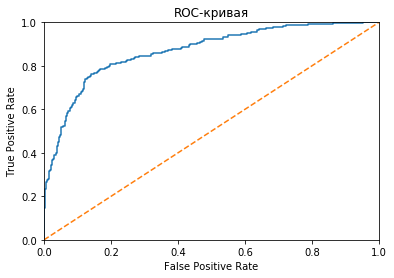

In [65]:
probabilities_test = new_best_ohe_forest_model.predict_proba(ohe_features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(ohe_target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [66]:
roc_auc_score(ohe_target_test, probabilities_one_test)

0.8686823513272515

Показатель roc_auc высок. Отметим, что по результатам на валидационном наборе данных объект с наибольшим f1 так же являлся объектом с наибольшим значением roc_auc.  

In [69]:
new_best_roc_auc_ohe_forest = ohe_forest_hyperparameters.query('roc_auc_score == roc_auc_score.max()')
new_best_roc_auc_ohe_forest

,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
106,8,90,6,1,0.8645,0.453431,0.793991,0.577223,0.875814


# Вывод

Качество модели удалось повысить благодаря борьбе с дисбалансом классов целевого признака и увеличению доли обучающего набора данных.  

Эффективным способом борьбы с дисбалансом оказалось увеличение выборки за счет дублирования объектов с положительным значением целевого признака.

В финальной модели показатель f1 на тестовом наборе данных превысил значение 0.62, а показатель roc-auc - 0.868.  

<font color='green'>Верно, upsampling позволил повысить качество модели. </font> <font color='blue'>Как я писала ранее, все-таки финальной моделью стоит считать случайный лес из раздела №3 решения. </font>



# Итоговый комментарий

Спасибо, ты проделал большую и очень качественную работу. Появятся вопросы – пиши, будем рады помочь :)

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*